# XGBoost Models

Given the tokenization encoding from **["multi-qa-mpnet-base-dot-v1",  "BAAI/bge-small-en-v1.5", "all-MiniLM-L6-v2"]** and some of the attributes from the post, predict whether the post is negative, positive, or neutral

In [1]:
# !pip install -r ../requirements.txt


In [2]:
model_names = ["multi-qa-mpnet-base-dot-v1",  
"BAAI/bge-small-en-v1.5",
"all-MiniLM-L6-v2"]

In [3]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import sys 
import requests

sys.path.append('../scripts/')

2025-04-04 01:49:04.502894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
pd.set_option('display.max_rows', 100)

In [5]:
random_state = 13

In [6]:
from access_data import authenticate_google_drive, grab_google_drive_folder_data

drive = authenticate_google_drive()
text_data = grab_google_drive_folder_data(drive=drive,filename="combined_labeled_data.csv")

Successfully loaded 'combined_labeled_data.csv' into a DataFrame!


In [7]:
%%time 

def create_embedding_dataframes(post_dataset, model, col_to_encode='combine_text'):

    dataset = post_dataset.copy().reset_index(drop=True)
    text_to_encode = post_dataset[col_to_encode]
    
    data_with_embdedding = pd.DataFrame()
    print('Started with model ' + model)
    load_model = SentenceTransformer(model, device="cpu") 
    post_embedding = load_model.encode(text_to_encode.values)
    data_with_embdedding = pd.concat([dataset, pd.DataFrame(post_embedding)], axis = 1)
    print('Done with model: ' + model)

    return data_with_embdedding
    

embedded_df_1 = create_embedding_dataframes(text_data, model_names[0])
embedded_df_2 = create_embedding_dataframes(text_data, model_names[1])
embedded_df_3 = create_embedding_dataframes(text_data, model_names[2])


Started with model multi-qa-mpnet-base-dot-v1
Done with model: multi-qa-mpnet-base-dot-v1
Started with model BAAI/bge-small-en-v1.5
Done with model: BAAI/bge-small-en-v1.5
Started with model all-MiniLM-L6-v2
Done with model: all-MiniLM-L6-v2
CPU times: user 1min 28s, sys: 25 s, total: 1min 53s
Wall time: 17.5 s


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report
import numpy as np
import pandas as pd 
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns 

In [9]:

def create_splits(embedded_df):
    label_mapping = {
        'Neutral': 0,
        'Negative': 1,
        'Positive': 2
    }
    embedded_df['label_encode'] = embedded_df['label'].map(label_mapping)

    ids = ['submission_id']
    tokenization_columns_numerical = list(embedded_df.columns)[7:]
    categorical = ['subreddit_topic', 'search_query']
    features = tokenization_columns_numerical + categorical
    target = 'label_encode'

    # Prevent data leakage 
    if target in features: 
        features.remove(target)

    X = embedded_df[features]
    y = embedded_df[target]
    id_df = embedded_df[ids]

    # Enable Categorical 
    for cat in categorical: 
        X[cat] = X[cat].astype("category") 
        embedded_df[cat] = embedded_df[cat].astype("category")

    X_train, X_test, y_train, y_test, id_train, id_test  = train_test_split(X, y, id_df, test_size=0.33, random_state=random_state,  stratify=y)
    return X_train, X_test, y_train, y_test, id_train, id_test 


def create_model_predictions(X_train, y_train): 
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    print("Class Weights:", class_weights)

    # Fit the model with sample weights
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    model= xgb.XGBClassifier(
        objective='multi:softmax',       
        num_class=3,                      
        eval_metric='mlogloss',           
        random_state=random_state,
        enable_categorical=True
    )

    model.fit(X_train, y_train)
    return model

def evaluate_model(model_name, model,X_train, X_test, y_train, y_test, id_train, id_test): 
    y_pred = model.predict(X_test)
    y_test = y_test.map({0:"Neutral", 1:"Negative", 2:"Positive"})
    y_pred = pd.Series(y_pred).map({0:"Neutral", 1:"Negative", 2:"Positive"})
    report = classification_report(y_test, y_pred)

    predicted_classes = y_test.unique()
    f1 = f1_score(y_test, y_pred, average=None, labels=predicted_classes)  # Per-class F1
    macro_f1 = f1_score(y_test, y_pred, average="macro")  # Macro F1 (since it's common for imbalanced datasets)

    # Print results
    print(f"\n{model_name} F1-score for each class:")
    for i, class_label in enumerate(predicted_classes):
        print(f"{class_label}: {f1[i]:.4f}")

    print(f"\n{model_name} Macro F1-score: {macro_f1:.4f}")

    # Print full classification report
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred, labels=["Neutral", "Negative", "Positive"])

    # Convert confusion matrix to a DataFrame for better readability
    cm_df = pd.DataFrame(cm, index=["Neutral", "Negative", "Positive"], columns=["Neutral", "Negative", "Positive"])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt="g", cmap="Blues", cbar=False)

    # Labels and title
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")

    # Show the plot
    plt.show()
    return y_pred, y_test



/tmp/ipykernel_12143/1737648643.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
/tmp/ipykernel_12143/1737648643.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")


Class Weights: [ 0.40384615  2.1        21.        ]

multi_qa_mpnet_base_dot_v1 F1-score for each class:
Neutral: 0.9091
Negative: 0.2500
Positive: 0.0000

multi_qa_mpnet_base_dot_v1 Macro F1-score: 0.3864


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


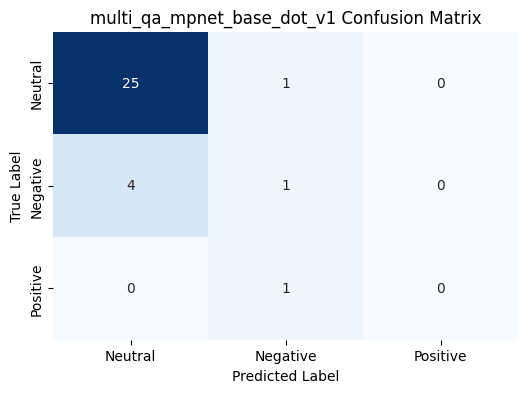

,submission_id,search_query,label_encode,multi_qa_mpnet_base_dot_v1_predicted_label
73,1chk891,Redfin,Neutral,Neutral
76,1c0vg34,Wells Fargo,Neutral,Neutral
24,1f1f3rz,Wells Fargo,Neutral,Neutral
32,1gum4oc,Rocket Mortgage,Neutral,Neutral
13,1bipbzp,Redfin,Neutral,Neutral


In [10]:
# Model One
idx = 0 
model_name = model_names[idx].replace('-', '_').replace('/', '_')

X_train, X_test, y_train, y_test, id_train, id_test  = create_splits(embedded_df_1)
model = create_model_predictions(X_train, y_train)
y_pred, y_test = evaluate_model(model_name, model , X_train, X_test, y_train, y_test, id_train, id_test)
y_pred = pd.DataFrame(y_pred, columns=[f'{model_name}_predicted_label'])
y_pred.index = y_test.index
combined_df_1 = pd.concat([id_test, X_test['search_query'], y_test, y_pred], axis=1)
combined_df_1.head() 


/tmp/ipykernel_12143/1737648643.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
/tmp/ipykernel_12143/1737648643.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")


Class Weights: [ 0.40384615  2.1        21.        ]

BAAI_bge_small_en_v1.5 F1-score for each class:
Neutral: 0.8727
Negative: 0.2500
Positive: 0.0000

BAAI_bge_small_en_v1.5 Macro F1-score: 0.3742


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


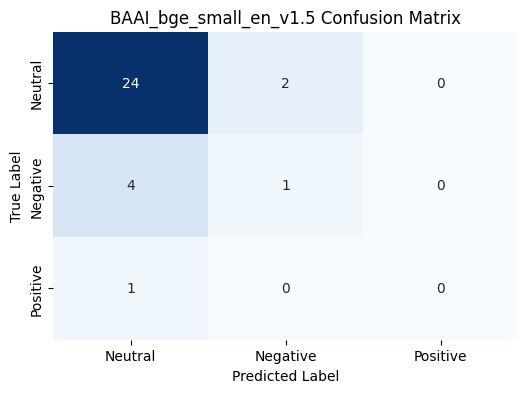

,submission_id,search_query,label_encode,BAAI_bge_small_en_v1.5_predicted_label
73,1chk891,Redfin,Neutral,Neutral
76,1c0vg34,Wells Fargo,Neutral,Neutral
24,1f1f3rz,Wells Fargo,Neutral,Neutral
32,1gum4oc,Rocket Mortgage,Neutral,Neutral
13,1bipbzp,Redfin,Neutral,Neutral


In [11]:
# Model Two
idx = 1 
model_name = model_names[idx].replace('-', '_').replace('/', '_')

X_train, X_test, y_train, y_test, id_train, id_test  = create_splits(embedded_df_2)
model = create_model_predictions(X_train, y_train)
y_pred, y_test = evaluate_model(model_name, model , X_train, X_test, y_train, y_test, id_train, id_test)
y_pred = pd.DataFrame(y_pred, columns=[f'{model_name}_predicted_label'])
y_pred.index = y_test.index
combined_df_2 = pd.concat([id_test, X_test['search_query'], y_test, y_pred], axis=1)
combined_df_2.head() 


/tmp/ipykernel_12143/1737648643.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")
/tmp/ipykernel_12143/1737648643.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat] = X[cat].astype("category")


Class Weights: [ 0.40384615  2.1        21.        ]

all_MiniLM_L6_v2 F1-score for each class:
Neutral: 0.8966
Negative: 0.0000
Positive: 0.0000

all_MiniLM_L6_v2 Macro F1-score: 0.2989


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


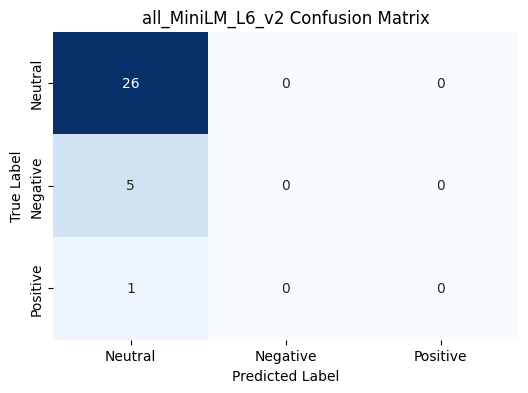

,submission_id,search_query,label_encode,all_MiniLM_L6_v2_predicted_label
73,1chk891,Redfin,Neutral,Neutral
76,1c0vg34,Wells Fargo,Neutral,Neutral
24,1f1f3rz,Wells Fargo,Neutral,Neutral
32,1gum4oc,Rocket Mortgage,Neutral,Neutral
13,1bipbzp,Redfin,Neutral,Neutral


In [12]:
# Model Three
idx = 2
model_name = model_names[idx].replace('-', '_').replace('/', '_')

X_train, X_test, y_train, y_test, id_train, id_test  = create_splits(embedded_df_3)
model = create_model_predictions(X_train, y_train)
y_pred, y_test = evaluate_model(model_name, model , X_train, X_test, y_train, y_test, id_train, id_test)
y_pred = pd.DataFrame(y_pred, columns=[f'{model_name}_predicted_label'])
y_pred.index = y_test.index
combined_df_3 = pd.concat([id_test, X_test['search_query'], y_test, y_pred], axis=1)
combined_df_3.head() 


## Get outputs

In [13]:
combined_final = pd.merge(combined_df_1, combined_df_2,on=['submission_id', 'search_query', 'label_encode'], how='left')
combined_final = pd.merge(combined_final, combined_df_3,on=['submission_id', 'search_query', 'label_encode'], how='left')
combined_final

,submission_id,search_query,label_encode,multi_qa_mpnet_base_dot_v1_predicted_label,BAAI_bge_small_en_v1.5_predicted_label,all_MiniLM_L6_v2_predicted_label
0,1chk891,Redfin,Neutral,Neutral,Neutral,Neutral
1,1c0vg34,Wells Fargo,Neutral,Neutral,Neutral,Neutral
2,1f1f3rz,Wells Fargo,Neutral,Neutral,Neutral,Neutral
3,1gum4oc,Rocket Mortgage,Neutral,Neutral,Neutral,Neutral
4,1bipbzp,Redfin,Neutral,Neutral,Neutral,Neutral
5,1ixgdz5,Wells Fargo,Neutral,Neutral,Neutral,Neutral
6,162dm96,Zillow,Neutral,Neutral,Neutral,Neutral
7,1iy5lng,Turbo Tax,Neutral,Neutral,Neutral,Neutral
8,1hn989h,Redfin,Neutral,Neutral,Neutral,Neutral
9,1cgf040,Rocket Mortgage,Neutral,Neutral,Neutral,Neutral


In [14]:
from access_data import authenticate_google_drive, save_google_drive_data

drive = authenticate_google_drive()
save_google_drive_data(drive=drive, 
                       dataframe =combined_final, 
                       filename="xgboost_models_test.csv")

File 'xgboost_models_test.csv' uploaded successfully to folder 1Ktcv4eaR7kH0teyGuLph4LSYWxI1qkIS!


,score
141,3.036084
120,1.629590
14,1.146148
140,1.132262
345,1.100245


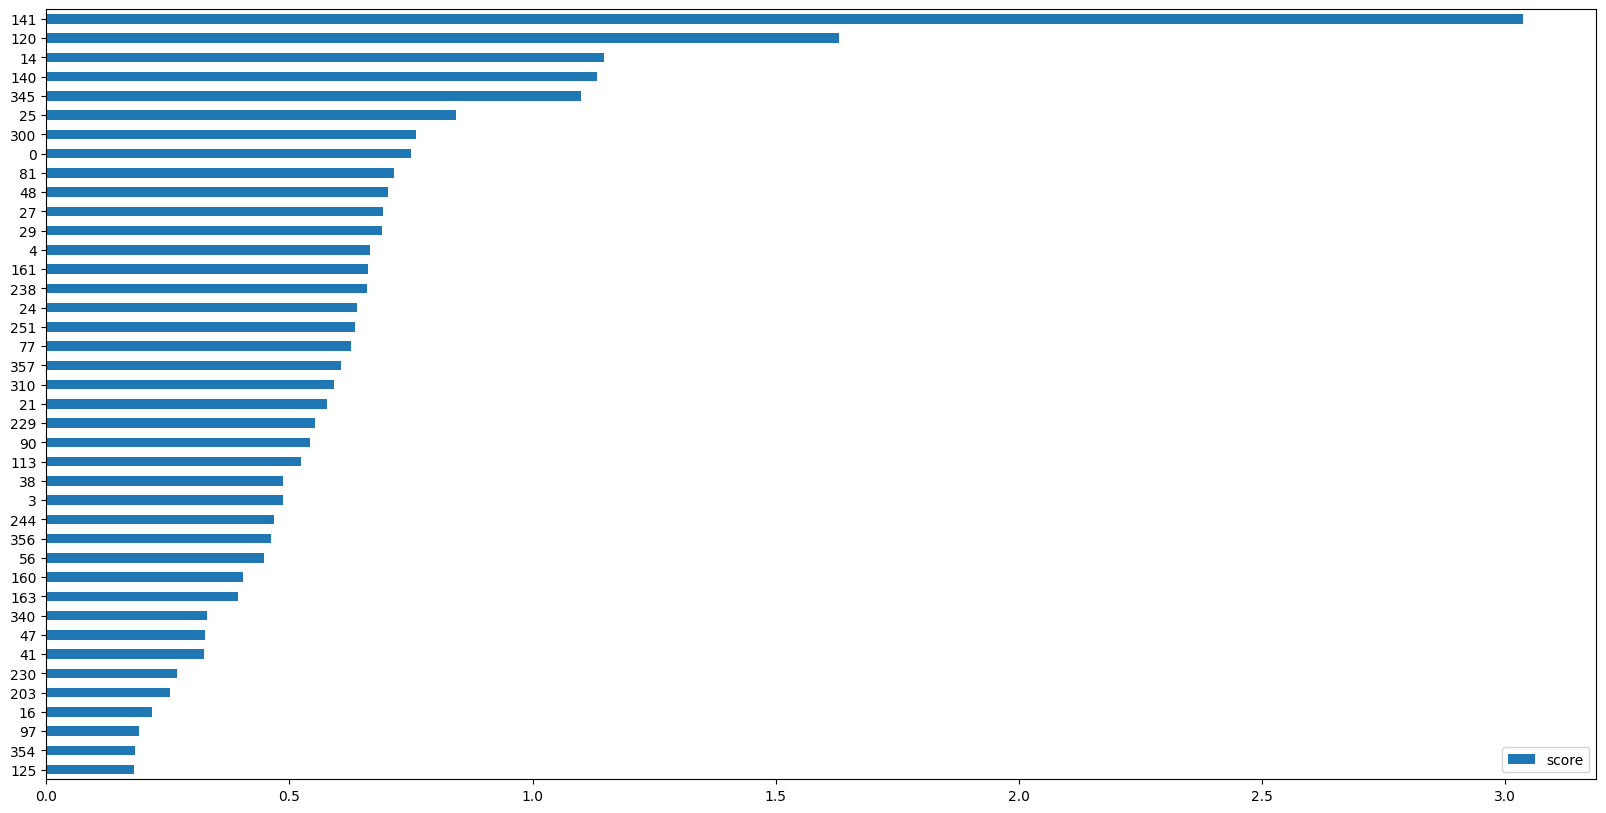

In [15]:
# ================================
# Feature Importance
# ================================

# --- 1. Extract raw feature importance ---
booster = model.get_booster()
feature_important = booster.get_score(importance_type='gain') 

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").sort_values("score", ascending=True).plot(kind='barh', figsize=(20, 10))
data.head()